# Gene Regulatory Network Reconstruction using Random Forest

This notebook implements a random forest-based approach to reconstruct the gene regulatory network from gene expression data.

## Imports

In [20]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

## Load Data

In [39]:
# Load expression data
data_path = "../../100_mr_100_cond/simulated_noNoise.txt"
expression_data = np.loadtxt(data_path)
expression_data = expression_data[1:, :]

# Split into TFs and target genes
n_tfs = 100
tf_expression = expression_data[:, :n_tfs]
target_expression = expression_data[:, n_tfs:]

# Load ground truth
ground_truth_path = "../../100_mr_100_cond/bipartite_GRN.csv"
ground_truth = pd.read_csv(ground_truth_path, header=None).values

print(f"Expression data shape: {expression_data.shape}")
print(f"TF expression shape: {tf_expression.shape}")
print(f"Target expression shape: {target_expression.shape}")
print(f"Ground truth shape: {ground_truth.shape}")
print(target_expression)

tf_expression_normalized = tf_expression.copy()
target_expression_normalized = target_expression.copy()

# Normalize TFs
for i in range(tf_expression.shape[1]):
    tf_expression_normalized[:, i] = tf_expression[:, i] / np.std(tf_expression[:, i])

# Normalize target genes
for i in range(target_expression.shape[1]):
    target_expression_normalized[:, i] = target_expression[:, i] / np.std(target_expression[:, i])

Expression data shape: (100, 200)
TF expression shape: (100, 100)
Target expression shape: (100, 100)
Ground truth shape: (487, 2)
[[10.9   5.41  5.76 ...  4.5  10.2   4.26]
 [12.2   7.37  4.51 ...  4.33 13.7   3.43]
 [11.7   2.11  9.77 ...  3.67  9.49  4.14]
 ...
 [13.2   2.82 10.8  ...  4.15 11.4   4.86]
 [10.7   6.87  8.74 ...  4.11 15.5   4.66]
 [12.9   6.75  3.99 ...  4.03 16.4   3.95]]


## Train Random Forest Models

In [47]:
def train_random_forests(tf_expression, target_expression, n_estimators=100):
    """Train random forest models for each target gene.
    
    Args:
        tf_expression: Expression data for transcription factors
        target_expression: Expression data for target genes
        n_estimators: Number of trees in the random forest
        
    Returns:
        List of trained random forest models
    """
    models = []
    
    for i in range(target_expression.shape[1]):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_samples=0.7, random_state=42)
        rf.fit(tf_expression, target_expression[:, i])
        models.append(rf)
        
    return models

# Train models
models = train_random_forests(tf_expression, target_expression)
models_normalized = train_random_forests(tf_expression, target_expression_normalized)
models_normalized_twice = train_random_forests(tf_expression_normalized, target_expression_normalized)


## Extract Feature Importance

In [48]:
def get_feature_importance_matrix(models):
    """Extract feature importance scores for all models.
    
    Args:
        models: List of trained random forest models
        
    Returns:
        Matrix of feature importance scores
    """
    n_tfs = models[0].n_features_in_
    n_targets = len(models)
    
    importance_matrix = np.zeros((n_tfs, n_targets))
    
    for i, model in enumerate(models):
        importance_matrix[:, i] = model.feature_importances_
        
    return importance_matrix

# Get importance matrix
importance_matrix = get_feature_importance_matrix(models)
importance_matrix_normalized = get_feature_importance_matrix(models_normalized)
importance_matrix_normalized_twice = get_feature_importance_matrix(models_normalized_twice)
# Normalize importance scores
importance_matrix = (importance_matrix - importance_matrix.min()) / (importance_matrix.max() - importance_matrix.min())
importance_matrix_normalized = (importance_matrix_normalized - importance_matrix_normalized.min()) / (importance_matrix_normalized.max() - importance_matrix_normalized.min())
importance_matrix_normalized_twice = (importance_matrix_normalized_twice - importance_matrix_normalized_twice.min()) / (importance_matrix_normalized_twice.max() - importance_matrix_normalized_twice.min())
print(importance_matrix.shape)

(100, 100)


## Threshold Selection and Network Reconstruction

c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hayde\anaconda3\envs\mlbiosci_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


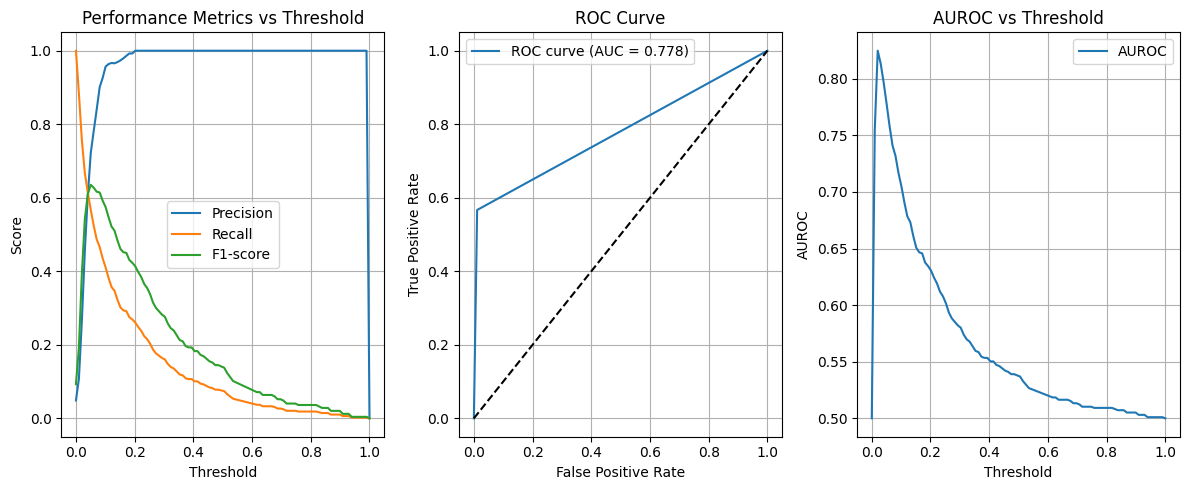

Best threshold: 0.051
Best F1-score: 0.635
AUROC: 0.778
Precision: 0.723
Recall: 0.567


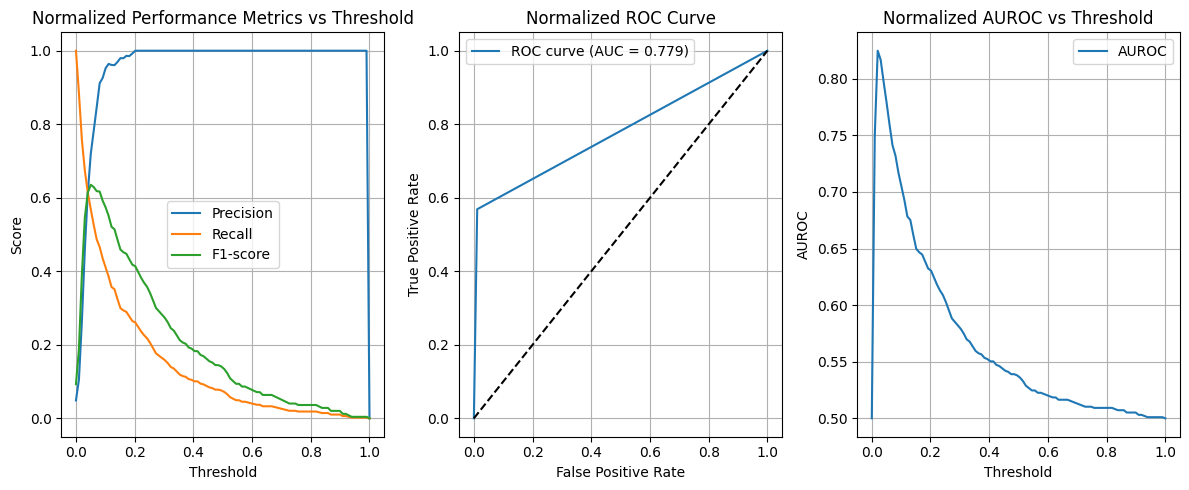


Normalized metrics:
Best threshold: 0.051
Best F1-score: 0.635
AUROC: 0.779
Precision: 0.719
Recall: 0.569


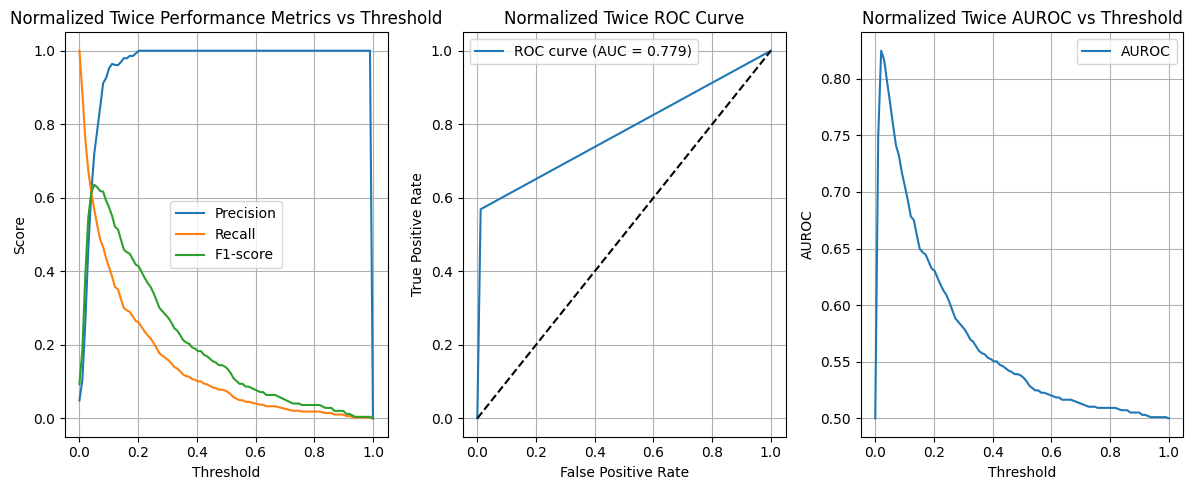


Normalized twice metrics:
Best threshold: 0.051
Best F1-score: 0.635
AUROC: 0.779
Precision: 0.719
Recall: 0.569


In [50]:
def reconstruct_network(importance_matrix, threshold):
    """Reconstruct network using importance threshold.
    
    Args:
        importance_matrix: Matrix of feature importance scores
        threshold: Threshold for considering a connection
        
    Returns:
        Binary adjacency matrix
    """
    return (importance_matrix > threshold).astype(int)

def create_adjacency_matrix(edge_list, n_tfs, n_targets):
    adj_matrix = np.zeros((n_tfs, n_targets))
    for tf, target in edge_list:
        adj_matrix[int(tf), int(target-100)] = 1
    return adj_matrix

def evaluate_network(predicted, ground_truth):
    """Calculate performance metrics.
    
    Args:
        predicted: Predicted network (binary matrix)
        ground_truth: Ground truth network (binary matrix)
        
    Returns:
        Dictionary of performance metrics
    """
    n_tfs, n_targets = predicted.shape
    ground_truth_matrix = create_adjacency_matrix(ground_truth, n_tfs, n_targets)
    
    # Calculate binary metrics
    precision = precision_score(ground_truth_matrix.flatten(), predicted.flatten())
    recall = recall_score(ground_truth_matrix.flatten(), predicted.flatten())
    f1 = f1_score(ground_truth_matrix.flatten(), predicted.flatten())
    
    # Calculate AUROC
    fpr, tpr, _ = roc_curve(ground_truth_matrix.flatten(), predicted.flatten())
    auroc = auc(fpr, tpr)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc,
        'fpr': fpr,
        'tpr': tpr
    }
# Try different thresholds
thresholds = np.linspace(0, 1, 100)
metrics = []
metrics_normalized = []
metrics_normalized_twice = []

for threshold in thresholds:
    predicted_network = reconstruct_network(importance_matrix, threshold)
    metric = evaluate_network(predicted_network, ground_truth)
    metric['threshold'] = threshold
    metrics.append(metric)

for threshold in thresholds:
    predicted_network = reconstruct_network(importance_matrix_normalized, threshold)
    metric = evaluate_network(predicted_network, ground_truth)
    metric['threshold'] = threshold
    metrics_normalized.append(metric)

for threshold in thresholds:
    predicted_network = reconstruct_network(importance_matrix_normalized_twice, threshold)
    metric = evaluate_network(predicted_network, ground_truth)
    metric['threshold'] = threshold
    metrics_normalized_twice.append(metric)
# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)
metrics_df_normalized = pd.DataFrame(metrics_normalized)
metrics_df_normalized_twice = pd.DataFrame(metrics_normalized_twice)

# Plot performance metrics
plt.figure(figsize=(12, 5))

# Plot 1: Threshold-based metrics
plt.subplot(1, 3, 1)
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['f1'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Plot 2: ROC curve
plt.subplot(1, 3, 2)
best_idx = metrics_df['f1'].argmax()
best_metric = metrics_df.iloc[best_idx]
plt.plot(best_metric['fpr'], best_metric['tpr'], label=f'ROC curve (AUC = {best_metric["auroc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(metrics_df['threshold'], metrics_df['auroc'], label='AUROC')
plt.xlabel('Threshold')
plt.ylabel('AUROC')
plt.title('AUROC vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best metrics
print(f"Best threshold: {best_metric['threshold']:.3f}")
print(f"Best F1-score: {best_metric['f1']:.3f}")
print(f"AUROC: {best_metric['auroc']:.3f}")
print(f"Precision: {best_metric['precision']:.3f}")
print(f"Recall: {best_metric['recall']:.3f}")

# Plot normalized performance metrics
plt.figure(figsize=(12, 5))

# Plot 1: Threshold-based metrics
plt.subplot(1, 3, 1)
plt.plot(metrics_df_normalized['threshold'], metrics_df_normalized['precision'], label='Precision')
plt.plot(metrics_df_normalized['threshold'], metrics_df_normalized['recall'], label='Recall') 
plt.plot(metrics_df_normalized['threshold'], metrics_df_normalized['f1'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Normalized Performance Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Plot 2: ROC curve
plt.subplot(1, 3, 2)
best_idx_normalized = metrics_df_normalized['f1'].argmax()
best_metric_normalized = metrics_df_normalized.iloc[best_idx_normalized]
plt.plot(best_metric_normalized['fpr'], best_metric_normalized['tpr'], label=f'ROC curve (AUC = {best_metric_normalized["auroc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Normalized ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(metrics_df_normalized['threshold'], metrics_df_normalized['auroc'], label='AUROC')
plt.xlabel('Threshold')
plt.ylabel('AUROC')
plt.title('Normalized AUROC vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Print best normalized metrics
print("\nNormalized metrics:")
print(f"Best threshold: {best_metric_normalized['threshold']:.3f}")
print(f"Best F1-score: {best_metric_normalized['f1']:.3f}")
print(f"AUROC: {best_metric_normalized['auroc']:.3f}")
print(f"Precision: {best_metric_normalized['precision']:.3f}")
print(f"Recall: {best_metric_normalized['recall']:.3f}")

# Plot normalized twice performance metrics
plt.figure(figsize=(12, 5))

# Plot 1: Threshold-based metrics
plt.subplot(1, 3, 1)
plt.plot(metrics_df_normalized_twice['threshold'], metrics_df_normalized_twice['precision'], label='Precision')
plt.plot(metrics_df_normalized_twice['threshold'], metrics_df_normalized_twice['recall'], label='Recall')
plt.plot(metrics_df_normalized_twice['threshold'], metrics_df_normalized_twice['f1'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Normalized Twice Performance Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Plot 2: ROC curve
plt.subplot(1, 3, 2)
best_idx_normalized_twice = metrics_df_normalized_twice['f1'].argmax()
best_metric_normalized_twice = metrics_df_normalized_twice.iloc[best_idx_normalized_twice]
plt.plot(best_metric_normalized_twice['fpr'], best_metric_normalized_twice['tpr'], label=f'ROC curve (AUC = {best_metric_normalized_twice["auroc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normalized Twice ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(metrics_df_normalized_twice['threshold'], metrics_df_normalized_twice['auroc'], label='AUROC')
plt.xlabel('Threshold')
plt.ylabel('AUROC')
plt.title('Normalized Twice AUROC vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best normalized twice metrics
print("\nNormalized twice metrics:")
print(f"Best threshold: {best_metric_normalized_twice['threshold']:.3f}")
print(f"Best F1-score: {best_metric_normalized_twice['f1']:.3f}")
print(f"AUROC: {best_metric_normalized_twice['auroc']:.3f}")
print(f"Precision: {best_metric_normalized_twice['precision']:.3f}")
print(f"Recall: {best_metric_normalized_twice['recall']:.3f}")



## Visualize Final Network

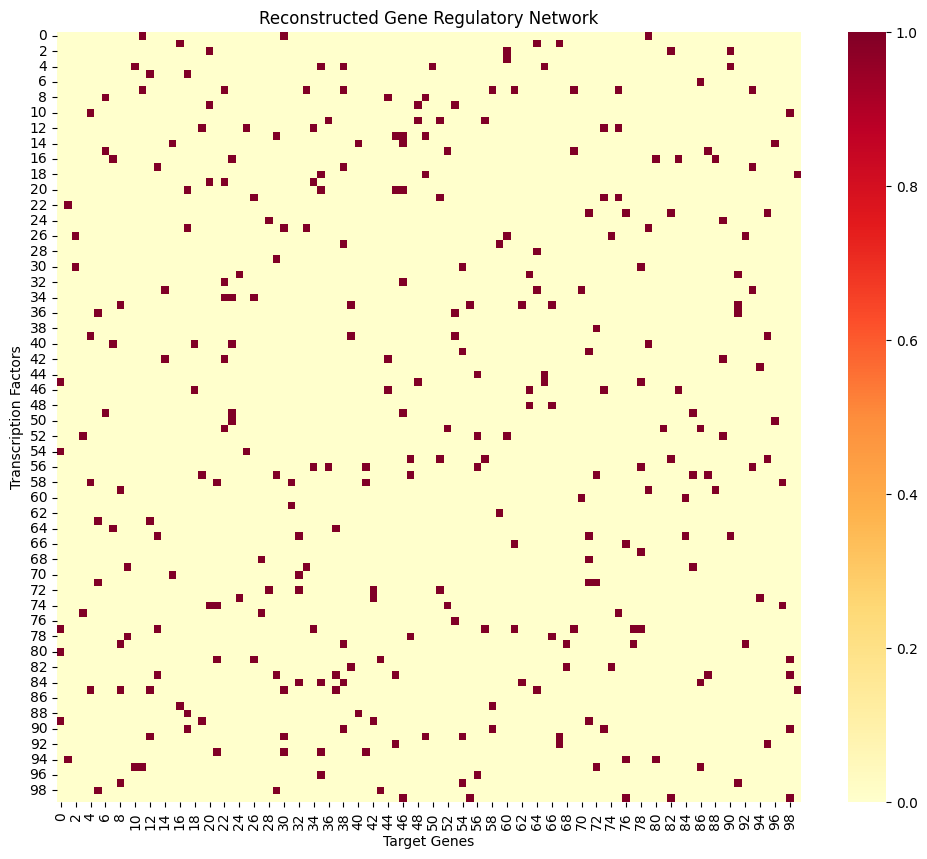

In [24]:
# Reconstruct network with best threshold
final_network = reconstruct_network(importance_matrix, best_threshold)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(final_network, cmap='YlOrRd')
plt.title('Reconstructed Gene Regulatory Network')
plt.xlabel('Target Genes')
plt.ylabel('Transcription Factors')
plt.show()